In [1]:
import csv
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

In [2]:
def plot_species(data, csv_path):
    # modified from deepac.eval.eval_species
    n_classes = 2
    species_list = []
    with open(csv_path, 'r') as class_csv:
        classreader = csv.reader(class_csv, delimiter=";")
        for row in classreader:
            species_list.append((int(row[0]), row[1], int(row[2])))

    used = 0
    y_result = []
    class_dict = {}
    labels = []
    for c in range(n_classes):
        class_dict[c] = []
    for row in species_list:
        labels.append(row[0])
        class_dict[row[0]].append((row[1], row[2]))

    species_starts_ends = []
    for c in range(n_classes):
        for species in class_dict[c]:
            species_starts_ends.append((used,used+species[1]))
            used = used + species[1]

    target_species = range(len(species_list))
    for target in target_species:
        sns.displot(data[species_starts_ends[target][0]:species_starts_ends[target][1]],
                    kde=True)
        plt.show()    


In [3]:
def plot_simspecies(spec_list, add_sigma=False):
    for spec in spec_list:
        if add_sigma:
            sns.displot(scipy.special.expit(spec), kde=True)
        else:
            sns.displot(spec, kde=True)
        plt.show()    

In [4]:
def logifunc(x,A,x0,k,off):
    return A / (1 + np.exp(-k*(x-x0)))+off

def plot_sigma(esz, sez, kind="scatter", sigma=True):
    marg_opt = {}
    joint_opt = {}

    g = (sns.jointplot(x=esz, y=sez, kind=kind, color='k', joint_kws=joint_opt, marginal_kws=marg_opt)).set_axis_labels("proba / E[s(z)]", "logit / s(E[z])]")

    g.ax_joint.set_xticks([0, 0.5, 1])
    g.ax_joint.set_yticks([0, 0.5, 1])
        
    if sigma:
        popt, pcov = scipy.optimize.curve_fit(logifunc, esz, sez)
        ref_data = np.linspace(0,1,100)
        formula="Fitted sigmoid"
        g.ax_joint.plot(ref_data, logifunc(ref_data, *popt), 'r-',label=formula)
        print(popt)
    plt.show()

In [5]:
def plot_dist(data):
    sns.displot(data.flatten(), kde=True)
    plt.show()
    print(f"mean: {data.mean()}; stddev: {data.std()}")

In [6]:
class_csv_path_f = "SIGMA/fungi-test.csv"
proba_f = np.load("SIGMA/res18-fungi24log-e012-predictions-fun_test_1.npy").flatten()
logit_f = np.load("SIGMA/res18-fungi24log-e012-predictions-fun_test_1_logit.npy").flatten()
#plot_species(logit_f, class_csv_path_f)

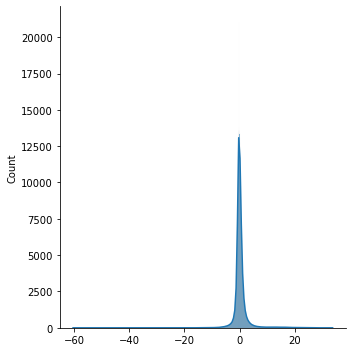

mean: 0.26087436079978943; stddev: 2.5303399562835693


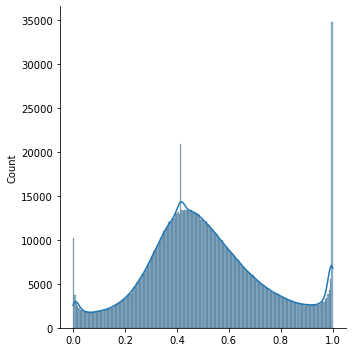

mean: 0.5060401558876038; stddev: 0.22614668309688568


In [7]:
plot_dist(logit_f)
plot_dist(proba_f)

In [8]:
#plot_species(proba_f, class_csv_path_f)

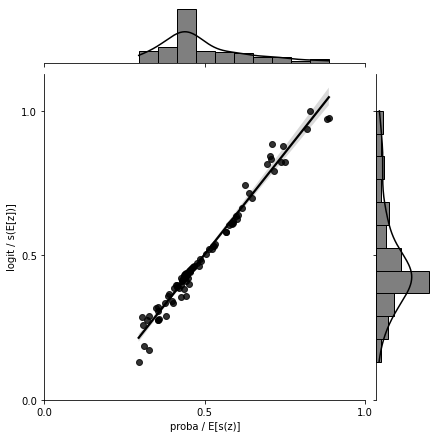

SpearmanrResult(correlation=0.9846544287818219, pvalue=7.811581624203214e-74)


In [9]:
proba_sf = np.load("SIGMA/res18-fungi24log-e012-predictions-fun_test_1-genomes.npy").flatten()
logit_sf = np.load("SIGMA/res18-fungi24log-e012-predictions-fun_test_1_logit-activ-genomes.npy").flatten()
plot_sigma(proba_sf, logit_sf, kind="reg", sigma=False)
print(scipy.stats.spearmanr(proba_sf, logit_sf))

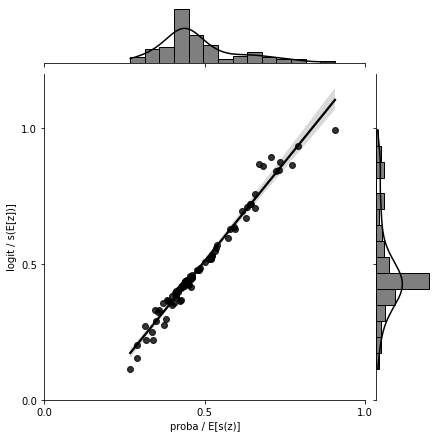

SpearmanrResult(correlation=0.9890726909320429, pvalue=8.548543854294629e-81)


In [10]:
proba_sf = np.load("SIGMA/res18-fungi24log-e012-predictions-fun_valfull-genomes.npy").flatten()
logit_sf = np.load("SIGMA/res18-fungi24log-e012-predictions-fun_valfull_logit-activ-genomes.npy").flatten()
plot_sigma(proba_sf, logit_sf, kind="reg", sigma=False)
print(scipy.stats.spearmanr(proba_sf, logit_sf))

In [11]:
import random as rn
seed = 0
np.random.seed(seed)
rn.seed(seed)

In [12]:
n_simspec = 100
#high m_scale / class separation / high abs(m_loc) / high n_simspec -> high tail coverage, sigmoid visible
#low m_scale & no class separation / low abs(m_loc)/ low n_simspec -> low tail coverage, sigmoid invisible
m_loc, m_scale = 0, 3
#high variance (d_loc) -> sigmoid
#low variance (d_loc and d_scale) -> linear
#heterogenous variance (low d_loc, high d_scale) -> some follow linear, some follow sigmoid
#no variance within a species -> linear!
#d_loc, d_scale = 3, 1, m_loc, m_scale = 0, 3 : phage-like sigma
#d_loc, d_scale = 0, 0, m_loc, m_scale = 0, 3 : perfect line (+ fitting err)
#d_loc, d_scale = 0.3, 1.5, m_loc, m_scale = 0, 0.5 : fung-like line with bell+clip proba distrib and higher spread near extremes
#d_loc, d_scale = 0.5, 5, m_loc, m_scale = 0, 3 : some follow linear, some follow sigmoid
d_loc, d_scale = 3, 1
means = scipy.stats.norm.rvs(m_loc, m_scale, size=n_simspec)
devs = scipy.stats.halfnorm.rvs(d_loc, d_scale, size=n_simspec)

In [13]:
n_reads = 1000
simspec_list = []
for s in range(n_simspec):
    simspec_list.append(scipy.stats.norm.rvs(means[s], devs[s], size=n_reads))
sim_z = np.asarray(simspec_list)

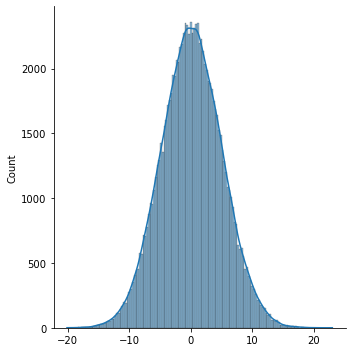

mean: 0.18569948697597327; stddev: 4.940708180794095


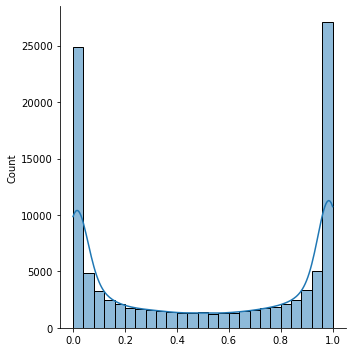

mean: 0.5127590078312637; stddev: 0.4164515701269206


In [14]:
plot_dist(sim_z)
plot_dist(scipy.special.expit(sim_z))

[ 1.01568348e+00  5.00805550e-01  1.08249271e+01 -7.34633094e-03]


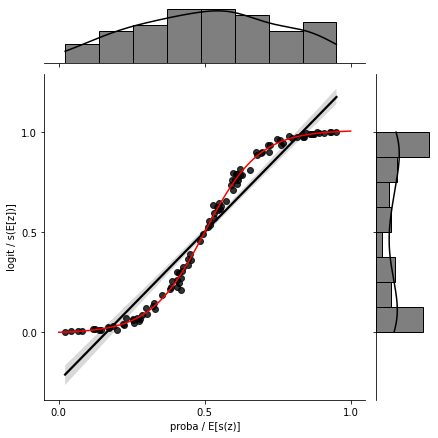

SpearmanrResult(correlation=0.9958835883588358, pvalue=5.309099185465995e-104)


In [15]:
sim_sez = scipy.special.expit(sim_z.mean(axis=1))
sim_esz = scipy.special.expit(sim_z).mean(axis=1)
plot_sigma(sim_esz, sim_sez, kind="reg", sigma=True)
print(scipy.stats.spearmanr(sim_esz, sim_sez))

In [16]:
#plot_simspecies(simspec_list)   

In [17]:
#plot_simspecies(simspec_list, add_sigma=True) 

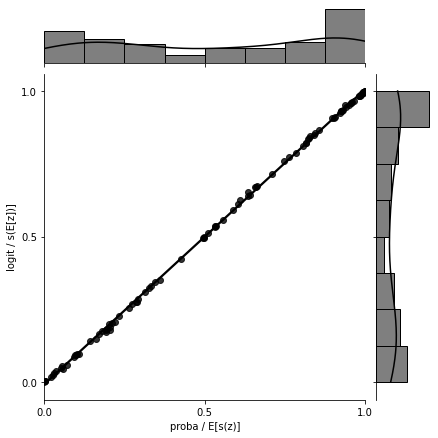

SpearmanrResult(correlation=0.9997599759975996, pvalue=1.9307055162900017e-164)


In [18]:
#high m_scale / class separation / high abs(m_loc) / high n_simspec -> high tail coverage, sigmoid visible
#low m_scale & no class separation / low abs(m_loc)/ low n_simspec -> low tail coverage, sigmoid invisible
m_loc, m_scale = 0, 3
#high variance (d_loc) -> sigmoid
#low variance (d_loc and d_scale) -> linear
#heterogenous variance (low d_loc, high d_scale) -> some follow linear, some follow sigmoid
#no variance within a species -> linear!
#d_loc, d_scale = 3, 1, m_loc, m_scale = 0, 3 : phage-like sigma
#d_loc, d_scale = 0, 0, m_loc, m_scale = 0, 3 : perfect line (+ fitting err)
#d_loc, d_scale = 0.3, 1.5, m_loc, m_scale = 0, 0.5 : fung-like line with bell+clip proba distrib and higher spread near extremes
#d_loc, d_scale = 0.5, 5, m_loc, m_scale = 0, 3 : some follow linear, some follow sigmoid
d_loc, d_scale = 0.25, 0.25
means = scipy.stats.norm.rvs(m_loc, m_scale, size=n_simspec)
devs = scipy.stats.halfnorm.rvs(d_loc, d_scale, size=n_simspec)

simspec_list = []
for s in range(n_simspec):
    simspec_list.append(scipy.stats.norm.rvs(means[s], devs[s], size=n_reads))
sim_z = np.asarray(simspec_list)

sim_sez = scipy.special.expit(sim_z.mean(axis=1))
sim_esz = scipy.special.expit(sim_z).mean(axis=1)
plot_sigma(sim_esz, sim_sez, kind="reg", sigma=False)
print(scipy.stats.spearmanr(sim_esz, sim_sez))

In [19]:
#m_loc_pos, m_scale_pos = 3, 3 -> beautiful sigma
#m_loc_pos, m_scale_pos = 3, 0.5 -> great separation, almost step (horizontal spread)
#m_loc_pos, m_scale_pos = 5, 2 -> bimodal z distrib (vir-like), sigma with an empty middle
m_loc_pos, m_scale_pos = 3, 2
d_loc_pos, d_scale_pos = 3, 1
means_pos = scipy.stats.norm.rvs(m_loc_pos, m_scale_pos, size=int(n_simspec/2))
devs_pos = scipy.stats.halfnorm.rvs(d_loc_pos, d_scale_pos, size=int(n_simspec/2))

m_loc_neg, m_scale_neg = -3, 2
d_loc_neg, d_scale_neg = 3, 1
means_neg = scipy.stats.norm.rvs(m_loc_neg, m_scale_neg, size=int(n_simspec/2))
devs_neg = scipy.stats.halfnorm.rvs(d_loc_neg, d_scale_neg, size=int(n_simspec/2))
                                 
means_bi = np.concatenate((means_pos, means_neg))
devs_bi = np.concatenate((devs_pos, devs_neg))

In [20]:
simspec_list_bi = []
for s in range(n_simspec):
    simspec_list_bi.append(np.concatenate((scipy.stats.norm.rvs(means_bi[s], devs_bi[s], size=n_reads),
                                           scipy.stats.norm.rvs(means_bi[s], devs_bi[s], size=n_reads))))
sim_bi_z = np.asarray(simspec_list_bi)

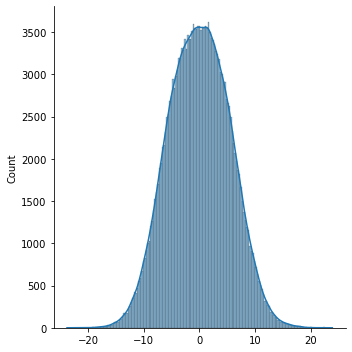

mean: -0.053735359686681874; stddev: 5.4672691328639855


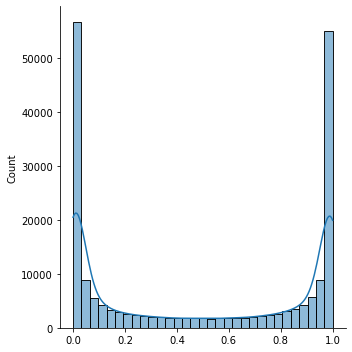

mean: 0.49644253561455925; stddev: 0.4299351605543155


In [21]:
plot_dist(sim_bi_z)
plot_dist(scipy.special.expit(sim_bi_z))

[ 1.01622439e+00  4.99824142e-01  1.06847159e+01 -9.49236174e-03]


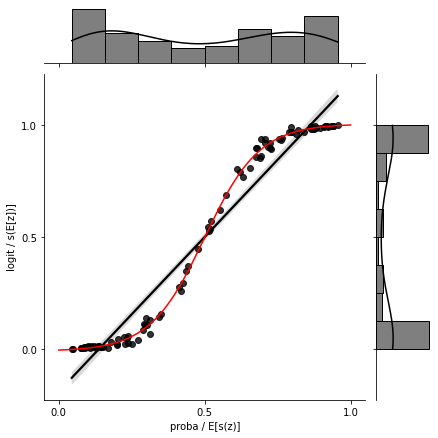

SpearmanrResult(correlation=0.9879747974797478, pvalue=2.864358579630425e-81)


In [22]:
sim_bi_sez = scipy.special.expit(sim_bi_z.mean(axis=1))
sim_bi_esz = scipy.special.expit(sim_bi_z).mean(axis=1)
plot_sigma(sim_bi_esz, sim_bi_sez, kind="reg", sigma=True)
print(scipy.stats.spearmanr(sim_bi_esz, sim_bi_sez))

In [23]:
#plot_simspecies(simspec_list_bi)   

In [24]:
#plot_simspecies(simspec_list_bi, add_sigma=True)   

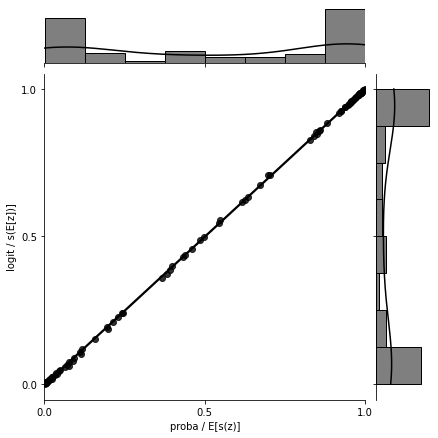

SpearmanrResult(correlation=0.9998559855985597, pvalue=2.606802309223637e-175)


In [25]:
#m_loc_pos, m_scale_pos = 3, 3 -> beautiful sigma
#m_loc_pos, m_scale_pos = 3, 0.5 -> great separation, almost step (horizontal spread)
#m_loc_pos, m_scale_pos = 5, 2 -> bimodal z distrib (vir-like), sigma with an empty middle
m_loc_pos, m_scale_pos = 3, 2
d_loc_pos, d_scale_pos = 0, 0
means_pos = scipy.stats.norm.rvs(m_loc_pos, m_scale_pos, size=int(n_simspec/2))
devs_pos = scipy.stats.halfnorm.rvs(d_loc_pos, d_scale_pos, size=int(n_simspec/2))

m_loc_neg, m_scale_neg = -3, 2
d_loc_neg, d_scale_neg = 0.25, 0.25
means_neg = scipy.stats.norm.rvs(m_loc_neg, m_scale_neg, size=int(n_simspec/2))
devs_neg = scipy.stats.halfnorm.rvs(d_loc_neg, d_scale_neg, size=int(n_simspec/2))
                                 
means_bi = np.concatenate((means_pos, means_neg))
devs_bi = np.concatenate((devs_pos, devs_neg))

simspec_list_bi = []
for s in range(n_simspec):
    simspec_list_bi.append(np.concatenate((scipy.stats.norm.rvs(means_bi[s], devs_bi[s], size=n_reads),
                                           scipy.stats.norm.rvs(means_bi[s], devs_bi[s], size=n_reads))))
sim_bi_z = np.asarray(simspec_list_bi)

sim_bi_sez = scipy.special.expit(sim_bi_z.mean(axis=1))
sim_bi_esz = scipy.special.expit(sim_bi_z).mean(axis=1)
plot_sigma(sim_bi_esz, sim_bi_sez, kind="reg", sigma=False)
print(scipy.stats.spearmanr(sim_bi_esz, sim_bi_sez))

In [26]:
#simple_loc, simple_scale = 0, 20 -> artifact line
#simple_loc, simple_scale = 0, 5 -> similar stddev to above
simple_loc, simple_scale = 0, 20
simple_z = scipy.stats.norm.rvs(simple_loc, simple_scale, size=int(n_simspec*n_reads))
sim_z_simp = np.reshape(simple_z, (n_simspec, n_reads))

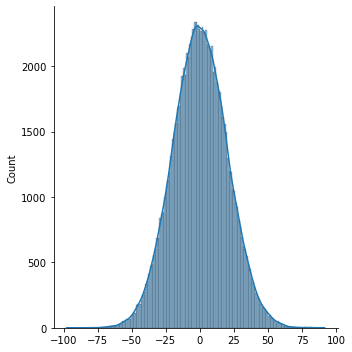

mean: 0.0547597393362579; stddev: 19.968688488573946


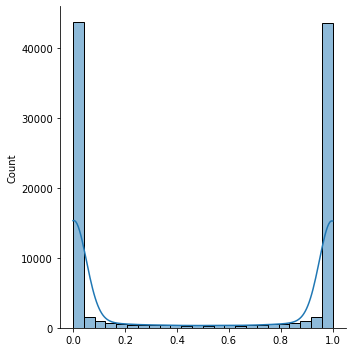

mean: 0.49909602435365874; stddev: 0.4797721645910918


In [27]:
plot_dist(sim_z_simp)
plot_dist(scipy.special.expit(sim_z_simp))

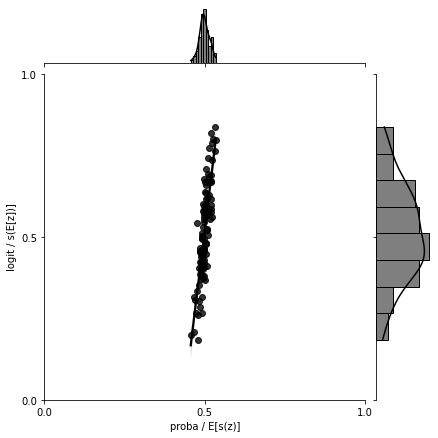

SpearmanrResult(correlation=0.8056405640564055, pvalue=5.16855971338552e-24)


In [28]:
sim_simp_sez = scipy.special.expit(sim_z_simp.mean(axis=1))
sim_simp_esz = scipy.special.expit(sim_z_simp).mean(axis=1)
plot_sigma(sim_simp_esz, sim_simp_sez, kind="reg", sigma=False)
print(scipy.stats.spearmanr(sim_simp_esz, sim_simp_sez))

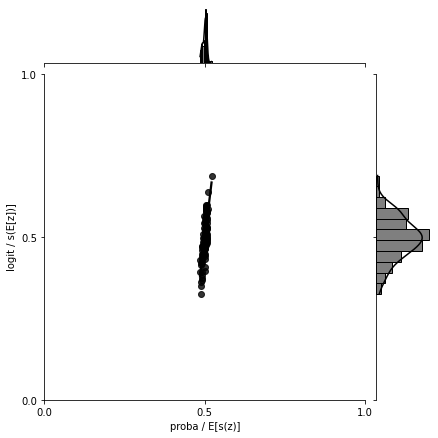

SpearmanrResult(correlation=0.7264686468646864, pvalue=1.1866491439430683e-17)


In [29]:
#simple_loc, simple_scale = 0, 20 -> artifact line
#simple_loc, simple_scale = 0, 5 -> similar stddev to above
simple_loc, simple_scale = 0, 20
simple_z = scipy.stats.norm.rvs(simple_loc, simple_scale, size=int(n_simspec*5*n_reads))
sim_z_simp = np.reshape(simple_z, (n_simspec, 5*n_reads))

sim_simp_sez = scipy.special.expit(sim_z_simp.mean(axis=1))
sim_simp_esz = scipy.special.expit(sim_z_simp).mean(axis=1)
plot_sigma(sim_simp_esz, sim_simp_sez, kind="reg", sigma=False)
print(scipy.stats.spearmanr(sim_simp_esz, sim_simp_sez))

## Conclusions
* High within-species variance: logit follows the normal distribution, proba follows bimodal -> sigmoid relationship
* Low within-species variance: both follow normal distribution -> linear relationship
* No within-species variance: perfectly linear

Reads with far-from-mean predictions get squashed in ESZ, so they don't influence the final prediction (y-hat) that much. In SEZ, they influence EZ a lot, and so also the y-hat.

So, *high confidence* predictions (outliers?) weight **more** in SEZ and **less** in ESZ. ESZ is more robust/conservative? SEZ yields more extreme predictions. If no species-level signal exists but read-wise variance is very high, SEZ is sensitive to noise and may generate artifacts (high confidence predictions where ESZ gives low confidence). They remain correlated so this may be a form of amplification.

[ 1.27944359  0.5198415   4.28643242 -0.11189241]


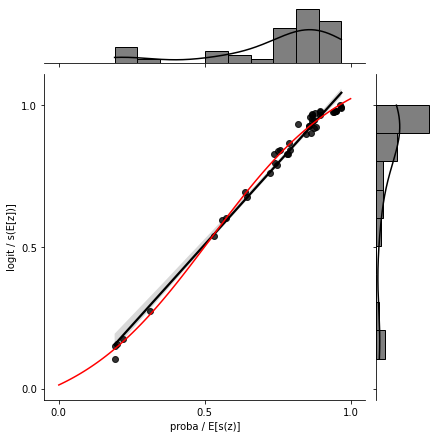

SpearmanrResult(correlation=0.9681159420289854, pvalue=1.7580515890264037e-27)
[ 1.08393443  0.50401246  6.68243194 -0.04201559]


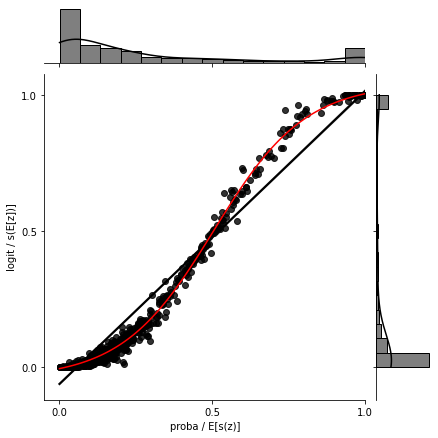

SpearmanrResult(correlation=0.984143322225022, pvalue=0.0)


In [30]:
proba_sb = np.load("SIGMA/illu-bac-predictions-test_1-genomes.npy").flatten()
logit_sb = np.load("SIGMA/illu-bac-predictions-test_1_logit-activ-genomes.npy").flatten()
plot_sigma(proba_sb, logit_sb, kind="reg", sigma=True)
print(scipy.stats.spearmanr(proba_sb, logit_sb))

proba_sv = np.load("SIGMA/illu-vir-predictions-all_test_1-genomes.npy").flatten()
logit_sv = np.load("SIGMA/illu-vir-predictions-all_test_1_logit-activ-genomes.npy").flatten()
plot_sigma(proba_sv, logit_sv, kind="reg", sigma=True)
print(scipy.stats.spearmanr(proba_sv, logit_sv))

In [31]:
class_csv_path_v = "SIGMA/vir-test.csv"
proba_v = np.load("SIGMA/illu-vir-predictions-all_test_1.npy").flatten()
logit_v = np.load("SIGMA/illu-vir-predictions-all_test_1_logit.npy").flatten()

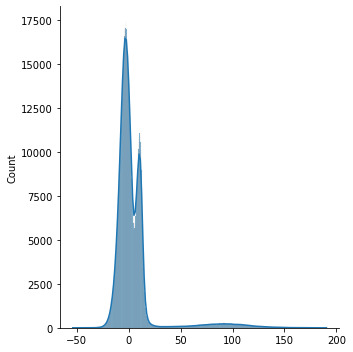

mean: 3.991541624069214; stddev: 21.31220817565918


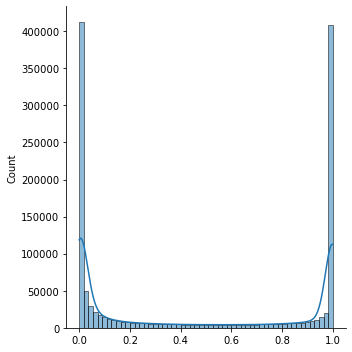

mean: 0.4678596258163452; stddev: 0.45256051421165466


In [32]:
plot_dist(logit_v)
plot_dist(proba_v)

In [33]:
class_csv_path_b = "SIGMA/bac-test.csv"
proba_b = np.load("SIGMA/illu-bac-predictions-test_1.npy").flatten()
logit_b = np.load("SIGMA/illu-bac-predictions-test_1_logit.npy").flatten()

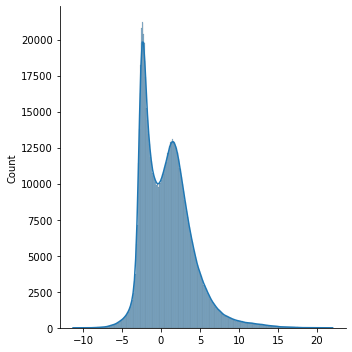

mean: 0.7950155138969421; stddev: 3.151881456375122


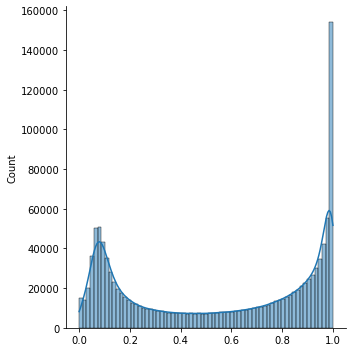

mean: 0.5524652600288391; stddev: 0.3691343367099762


In [34]:
plot_dist(logit_b)
plot_dist(proba_b)